In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML, Video

# Read Image

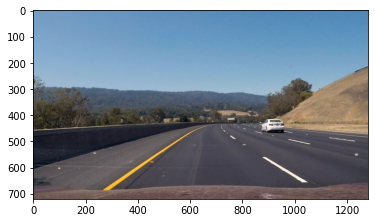

In [2]:
def readImage(path):
    img1 = cv2.imread(path)
    img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    return img2

path = "test3.jpg"
img = readImage(path)
plt.imshow(img)

# Thresholding

In [3]:
def threshold_rel(img, lo, hi):
    vmin = np.min(img)
    vmax = np.max(img)
    vlo = vmin + (vmax - vmin) * lo
    vhi = vmin + (vmax - vmin) * hi
    return np.uint8((img >= vlo) & (img <= vhi)) * 255

def threshold_abs(img, lo, hi):
    return np.uint8((img >= lo) & (img <= hi)) * 255

In [4]:
def get_lanes(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h_channel = hls[:, :, 0]
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    v_channel = hsv[:, :, 2]
    right_lane = threshold_rel(l_channel, 0.8, 1)
    right_lane[:, :750] = 0
    right_lane[:350, :] = 0

    left_lane = threshold_abs(h_channel, 20, 30)
    left_lane &= threshold_rel(v_channel, 0.7, 1.0)
    left_lane[:, 550:] = 0
    left_lane[:350, :] = 0
    img3 = left_lane | right_lane
    return img3, right_lane, left_lane

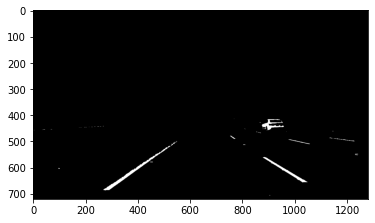

In [5]:
img2, img5, img6 = get_lanes(img)
plt.imshow(img2,cmap='gray')

# Prespective Transform

In [6]:
def perspective_transform():
    src = np.float32([(550, 460),  # top-left
                      (150, 720),  # bottom-left
                      (1200, 720),  # bottom-right
                      (770, 460)])  # top-right
    dst = np.float32([(100, 0),
                      (100, 720),
                      (1100, 720),
                      (1100, 0)])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


def warp_perspective(img, imgsize, M):
    return cv2.warpPerspective(img, M, imgsize, cv2.INTER_LINEAR)


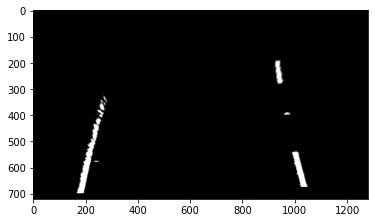

In [7]:
M, Minv = perspective_transform()
warped_img1 = warp_perspective(img2, img2.shape[1::-1], M)
plt.imshow(warped_img1,cmap='gray')

# Lanes

In [8]:
def hist(img):
    bottom_half = img[img.shape[0] // 2:, :]
    return np.sum(bottom_half, axis=0)

In [9]:
class LaneLines:
    """ Class containing information about detected lane lines.

    Attributes:
        left_fit (np.array): Coefficients of a polynomial that fit left lane line
        right_fit (np.array): Coefficients of a polynomial that fit right lane line
        parameters (dict): Dictionary containing all parameters needed for the pipeline
        debug (boolean): Flag for debug/normal mode
    """

    def __init__(self):
        """Init Lanelines.

        Parameters:
            left_fit (np.array): Coefficients of polynomial that fit left lane
            right_fit (np.array): Coefficients of polynomial that fit right lane
            binary (np.array): binary image
        """
        self.left_fit = None
        self.right_fit = None
        self.binary = None
        self.nonzero = None
        self.nonzerox = None
        self.nonzeroy = None
        self.clear_visibility = True
        self.dir = []

        # HYPERPARAMETERS
        # Number of sliding windows
        self.nwindows = 9
        # Width of the the windows +/- margin
        self.margin = 100
        # Mininum number of pixels found to recenter window
        self.minpix = 50

    def forward(self, img):
        """Take a image and detect lane lines.

        Parameters:
            img (np.array): An binary image containing relevant pixels

        Returns:
            Image (np.array): An RGB image containing lane lines pixels and other details
        """
        self.extract_features(img)
        return self.fit_poly(img)

    def pixels_in_window(self, center, margin, height):
        """ Return all pixel that in a specific window

        Parameters:
            center (tuple): coordinate of the center of the window
            margin (int): half width of the window
            height (int): height of the window

        Returns:
            pixelx (np.array): x coordinates of pixels that lie inside the window
            pixely (np.array): y coordinates of pixels that lie inside the window
        """
        topleft = (center[0] - margin, center[1] - height // 2)
        bottomright = (center[0] + margin, center[1] + height // 2)

        condx = (topleft[0] <= self.nonzerox) & (self.nonzerox <= bottomright[0])
        condy = (topleft[1] <= self.nonzeroy) & (self.nonzeroy <= bottomright[1])
        return self.nonzerox[condx & condy], self.nonzeroy[condx & condy]

    def extract_features(self, img):
        """ Extract features from a binary image

        Parameters:
            img (np.array): A binary image
        """
        self.img = img
        # Height of of windows - based on nwindows and image shape
        self.window_height = np.int32(img.shape[0] // self.nwindows)

        # Identify the x and y positions of all nonzero pixel in the image
        self.nonzero = img.nonzero()
        self.nonzerox = np.array(self.nonzero[1])
        self.nonzeroy = np.array(self.nonzero[0])

    def find_lane_pixels(self, img):
        """Find lane pixels from a binary warped image.

        Parameters:
            img (np.array): A binary warped image

        Returns:
            leftx (np.array): x coordinates of left lane pixels
            lefty (np.array): y coordinates of left lane pixels
            rightx (np.array): x coordinates of right lane pixels
            righty (np.array): y coordinates of right lane pixels
            out_img (np.array): A RGB image that use to display result later on.
        """
        assert (len(img.shape) == 2)

        # Create an output image to draw on and visualize the result
        out_img = np.dstack((img, img, img))

        histogram = hist(img)
        midpoint = histogram.shape[0] // 2
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Current position to be update later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base
        y_current = img.shape[0] + self.window_height // 2

        # Create empty lists to reveice left and right lane pixel
        leftx, lefty, rightx, righty = [], [], [], []

        # Step through the windows one by one
        for _ in range(self.nwindows):
            y_current -= self.window_height
            center_left = (leftx_current, y_current)
            center_right = (rightx_current, y_current)

            good_left_x, good_left_y = self.pixels_in_window(center_left, self.margin, self.window_height)
            good_right_x, good_right_y = self.pixels_in_window(center_right, self.margin, self.window_height)

            # Append these indices to the lists
            leftx.extend(good_left_x)
            lefty.extend(good_left_y)
            rightx.extend(good_right_x)
            righty.extend(good_right_y)

            if len(good_left_x) > self.minpix:
                leftx_current = np.int32(np.mean(good_left_x))
            if len(good_right_x) > self.minpix:
                rightx_current = np.int32(np.mean(good_right_x))

        return leftx, lefty, rightx, righty, out_img

    def fit_poly(self, img):
        """Find the lane line from an image and draw it.

        Parameters:
            img (np.array): a binary warped image

        Returns:
            out_img (np.array): a RGB image that have lane line drawn on that.
        """

        leftx, lefty, rightx, righty, out_img = self.find_lane_pixels(img)

        if len(lefty) > 1500:
            self.left_fit = np.polyfit(lefty, leftx, 2)
        if len(righty) > 1500:
            self.right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        maxy = img.shape[0] - 1
        miny = img.shape[0] // 3
        if len(lefty):
            # maxy = max(maxy, np.max(lefty))
            miny = min(miny, np.min(lefty))

        if len(righty):
            # maxy = max(maxy, np.max(righty))
            miny = min(miny, np.min(righty))

        ploty = np.linspace(miny, maxy, img.shape[0])
        #print(type(self.left_fit),type(self.right_fit))
        left_fitx = self.left_fit[0] * ploty ** 2 + self.left_fit[1] * ploty + self.left_fit[2]
        right_fitx = self.right_fit[0] * ploty ** 2 + self.right_fit[1] * ploty + self.right_fit[2]
        out_img1= np.copy(out_img)
        # Visualization
        for i, y in enumerate(ploty):
            l = int(left_fitx[i])
            r = int(right_fitx[i])
            y = int(y)
            cv2.line(out_img, (l, y), (r, y), (0, 255, 0))
            cv2.line(out_img, (r, y), (r, y), (255, 0, 0),10)
            cv2.line(out_img, (l, y), (l, y), (255, 0, 0),10)
            cv2.line(out_img1, (r, y), (r, y), (255, 0, 0),5)
            cv2.line(out_img1, (l, y), (l, y), (255, 0, 0),5)

        lR, rR, pos = self.measure_curvature()
        
        return out_img,out_img1###########################################

    def plot(self, out_img):
        np.set_printoptions(precision=6, suppress=True)
        lR, rR, pos = self.measure_curvature()

        value = None
        if abs(self.left_fit[0]) > abs(self.right_fit[0]):
            value = self.left_fit[0]
        else:
            value = self.right_fit[0]

        if abs(value) <= 0.00015:
            self.dir.append('F')
        elif value < 0:
            self.dir.append('L')
        else:
            self.dir.append('R')

        if len(self.dir) > 10:
            self.dir.pop(0)

        W = 400
        H = 300
        widget = np.copy(out_img[:H, :W])
        widget //= 2
        widget[0, :] = [0, 0, 255]
        widget[-1, :] = [0, 0, 255]
        widget[:, 0] = [0, 0, 255]
        widget[:, -1] = [0, 0, 255]
        out_img[:H, :W] = widget

        direction = max(set(self.dir), key=self.dir.count)
        curvature_msg = "Curvature = {:.0f} m".format(min(lR, rR))

        if direction in 'LR':
            cv2.putText(out_img, curvature_msg, org=(10, 100), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
                        color=(255, 255, 255), thickness=2)

        cv2.putText(
            out_img,
            "Vehicle is {:.2f} m away from center".format(pos),
            org=(10, 200),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.66,
            color=(255, 255, 255),
            thickness=2)

        return out_img

    def measure_curvature(self):
        ym = 30 / 720
        xm = 3.7 / 700

        left_fit = self.left_fit.copy()
        right_fit = self.right_fit.copy()
        y_eval = 700 * ym

        # Compute R_curve (radius of curvature)
        left_curveR = ((1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
        right_curveR = ((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit[0])

        xl = np.dot(self.left_fit, [700 ** 2, 700, 1])
        xr = np.dot(self.right_fit, [700 ** 2, 700, 1])
        pos = (1280 // 2 - (xl + xr) // 2) * xm
        return left_curveR, right_curveR, pos

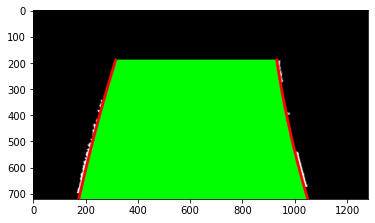

In [10]:
laneLines = LaneLines()
img3,img4 = laneLines.forward(warped_img1)
plt.imshow(img3,cmap='gray')

# Return to Actual Scale

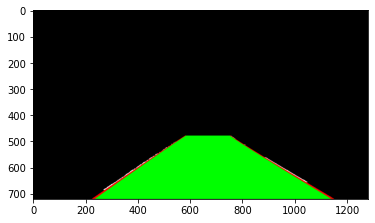

In [11]:
warped_img2 = warp_perspective(img3, img3.shape[1::-1], Minv)
plt.imshow(warped_img2,cmap='gray')

# Add Effects to actual picture

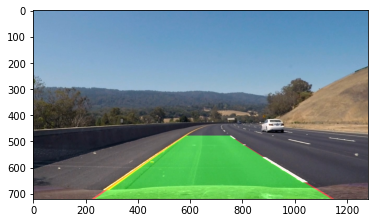

In [12]:
out_img = cv2.addWeighted(img, 1, warped_img2, 0.5, 0)
plt.imshow(out_img)

(720, 1280, 3)


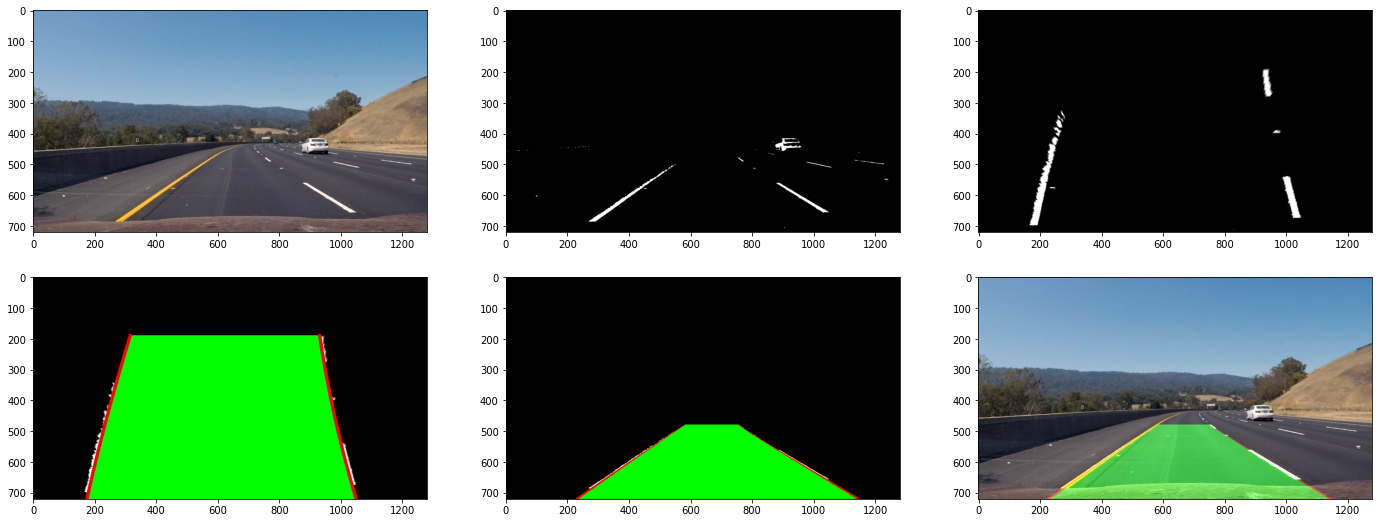

In [13]:
lane_lines = LaneLines()
def plot(img):
    print(img.shape)
    f = plt.figure(figsize=(24, 9))
    ax1 = f.add_subplot(2, 3, 1)
    ax1.imshow(img,  vmin=0, vmax=255)
    img2, i, k = get_lanes(img)
    ax2 = f.add_subplot(2, 3, 2)
    ax2.imshow(img2, cmap='gray', vmin=0, vmax=255)
    M, Minv = perspective_transform()
    warped_img1 = warp_perspective(img2, img2.shape[1::-1], M)
    ax3 = f.add_subplot(2, 3, 3)
    ax3.imshow(warped_img1, cmap='gray', vmin=0, vmax=255)
    img3,im = lane_lines.forward(warped_img1)
    ax4 = f.add_subplot(2, 3, 4)
    ax4.imshow(img3, cmap='gray', vmin=0, vmax=255)
    warped_img2 = warp_perspective(img3, img3.shape[1::-1], Minv)
    ax5 = f.add_subplot(2, 3, 5)
    ax5.imshow(warped_img2, cmap='gray', vmin=0, vmax=255)
    out_img = cv2.addWeighted(img, 1, warped_img2, 0.5, 0)
    ax6 = f.add_subplot(2, 3, 6)
    ax6.imshow(out_img, vmin=0, vmax=255)
    
plot(img)

# Debug Mode

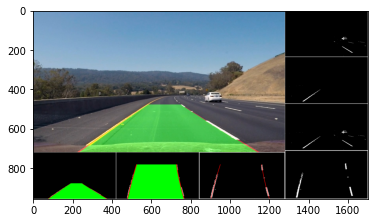

In [14]:
def resizing(img, ratio = 0.33):
    return cv2.resize(img, (int(img.shape[1] * ratio), int(img.shape[0] * ratio)))

def channels_3(img):
    if len(img.shape) < 3:
        return np.dstack((img, img, img))
    return img

def margin(img, thickness = 2):
    img[:thickness, :] = 255
    img[img.shape[0]-thickness:, :] = 255
    img[:, :thickness] = 255
    img[:, img.shape[1]-thickness:] = 255
    return img
    
# plt.imshow(margin(img2), cmap = 'gray')
    

def plot_debug(img, img1, img2, img3, img4, img5, img6, img7):
    out_img = np.concatenate((resizing(channels_3(margin(img1))), resizing(channels_3(margin(img2)))), axis = 0)
    out_img = np.concatenate((out_img, resizing(channels_3(margin(img3)))), axis = 0)
    img4 = cv2.resize(img4, (int(img4.shape[1] * 0.33), int(img4.shape[0] * 0.342)))
    out_img = np.concatenate((out_img, channels_3(margin(img4))), axis = 0)
    
    out_img1 = np.concatenate((resizing(channels_3(margin(img7))), resizing(channels_3(margin(img6)))), axis = 1)
    img5 = cv2.resize(img5, (int(img5.shape[1] * 0.341), int(img5.shape[0] * 0.33)))
    out_img1 = np.concatenate((out_img1, channels_3(margin(img5))), axis = 1)
    out_img1 = np.concatenate((channels_3(img), out_img1), axis = 0)

    out_img = np.concatenate((out_img1, out_img), axis = 1)
    plt.imshow(out_img)

plot_debug(out_img, img5, img6, img2, warped_img1, img4, img3, warped_img2)

# Process on video

In [15]:
lanelines = LaneLines()
def process_image(img):
    M, Minv = perspective_transform()
    warped_img1 = warp_perspective(img, img.shape[1::-1], M)
    img2 = get_lanes(warped_img1)
    img3,im = lanelines.forward(img2)
    warped_img2 = warp_perspective(img3, img3.shape[1::-1], Minv)
    out_img = cv2.addWeighted(img, 1, warped_img2, 0.5, 0)
    img4 = lanelines.plot(out_img)
    return img4

In [16]:
clip = VideoFileClip("project_video.mp4")

OSError: MoviePy error: the file project_video.mp4 could not be found!
Please check that you entered the correct path.

In [ ]:
out_clip = clip.fl_image( process_image )
out_clip.write_videofile("tmp.mp4", audio=False)

In [ ]:
Video("tmp.mp4")